# Code for Oscilloscope

### Goal:
- read and plot single events of the oscilloscope from data_oscill
- Gaußfit for $\Delta t$ between events
- Categorizing single, double, triple photon signals to check statistics of manufacturer 

In [60]:
import pandas as pd
import numpy as np
import scipy as sp
import pyarrow.parquet as pq
import time
import matplotlib.pyplot as plt
import argparse
import csv
import pyarrow as pa 

In [25]:
df = pd.read_csv('data_oscill/Multiple_WFM_Run4_list.Wfm.csv', sep = ";")

In [26]:
df.head(10)

,,-30.7193817643484
-0.038303,0.000290,-0.004366
-0.039692,0.000515,-0.004514
-0.040928,0.000731,-0.004563
-0.041700,0.000923,-0.004526
-0.041545,0.001058,-0.004421
-0.040542,0.001136,-0.004267
-0.038766,0.001151,-0.004094
-0.036373,0.001123,-0.003921
-0.033671,0.001068,-0.003767
-0.031123,0.001009,-0.003631


### general structure of data
- each wafeform (wfm) is initiated by the time stamp of the waveform (line with only one element)
- every following line (with three elements) has time-steps of 4e-011 (according to info file under resolution)


### approach
- probably not using pandas but simpler loop system
- loop on each line and see how many elements
- for each loop attach an x-coordinate while looping with used resolution

In [62]:
RESOLUTION = 4e-11
BUFFER_SIZE = 50_000  # number of rows to buffer before writing

def convert_csv_to_csv_and_parquet(in_path, out_csv_path, out_parquet_path):
    buffer = []
    event_id = -1
    t0 = None
    idx = 0

    parquet_writer = None

    with open(in_path) as fin, open(out_csv_path, "w") as fout:
        # write CSV header
        fout.write("event_id,timestamp,x,y,z\n")

        for line in fin:
            line = line.strip()
            if not line:
                continue

            parts = line.split(";")

            # new event
            if len(parts) == 1:
                event_id += 1
                t0 = float(parts[0])
                idx = 0
                continue

            # data row
            if len(parts) == 3:
                timestamp = t0 + idx * RESOLUTION
                idx += 1
                x, y, z = map(float, parts)

                # add to buffer
                buffer.append([event_id, timestamp, x, y, z])

                # flush buffer if full
                if len(buffer) >= BUFFER_SIZE:
                    # write CSV
                    for row in buffer:
                        fout.write(f"{row[0]},{row[1]},{row[2]},{row[3]},{row[4]}\n")

                    # write Parquet
                    df = pd.DataFrame(buffer, columns=["event_id", "timestamp", "Ch_1", "Ch_2", "Ch_3"])
                    table = pa.Table.from_pandas(df)
                    if parquet_writer is None:
                        parquet_writer = pq.ParquetWriter(out_parquet_path, table.schema, compression='snappy')
                    parquet_writer.write_table(table)

                    buffer = []

                continue

            raise ValueError(f"Unexpected format: {line}")

        # flush remaining buffer
        if buffer:
            for row in buffer:
                fout.write(f"{row[0]},{row[1]},{row[2]},{row[3]},{row[4]}\n")
            df = pd.DataFrame(buffer, columns=["event_id", "timestamp", "Ch_1", "Ch_2", "Ch_3"])
            table = pa.Table.from_pandas(df)
            if parquet_writer is None:
                parquet_writer = pq.ParquetWriter(out_parquet_path, table.schema, compression='snappy')
            parquet_writer.write_table(table)

        if parquet_writer:
            parquet_writer.close()


In [64]:
convert_csv_to_csv_and_parquet('data_oscill/Multiple_WFM_Run4_list.Wfm.csv', 'data_oscill/cleaned_Run4.csv', 'data_oscill/cleaned_Run4.parquet')

### plotting
$\rightarrow$ let's now plot one event to see if it coincides with what we see on the oscilloscope

In [114]:
def plot_target_event(cleaned_data, target_event = 0):
    df = pd.read_csv(cleaned_data)

    # filter for target event
    event= df[df['event_id'] == target_event] 

    # plot
    plt.figure(figsize=(10,6))
    plt.plot(event["timestamp"], event["x"], label="Laser Trigger")
    plt.plot(event["timestamp"], event["y"], label="MCP PMT Camera")
    plt.plot(event["timestamp"], event["z"], label="HPD")
    plt.xlabel("Timestamp (s)")
    plt.ylabel("Signal")
    plt.title(f"Event {target_event}")
    plt.legend()
    plt.show()

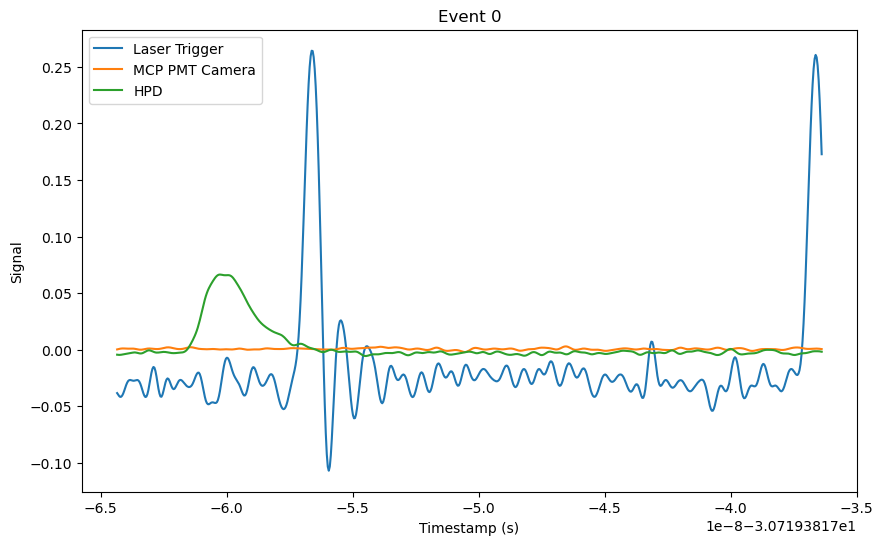

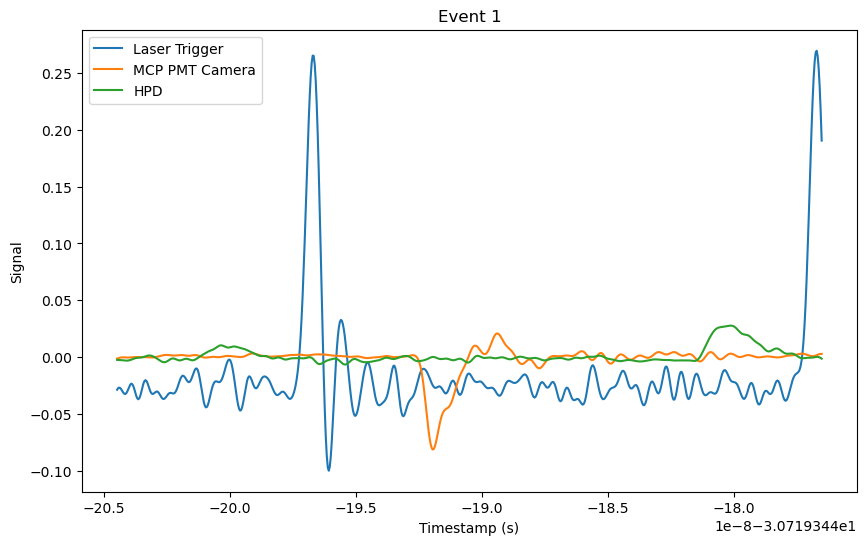

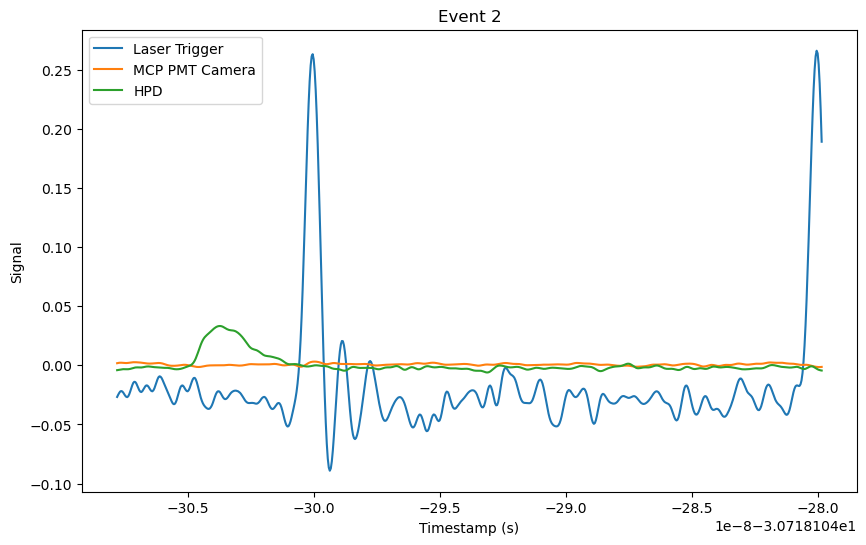

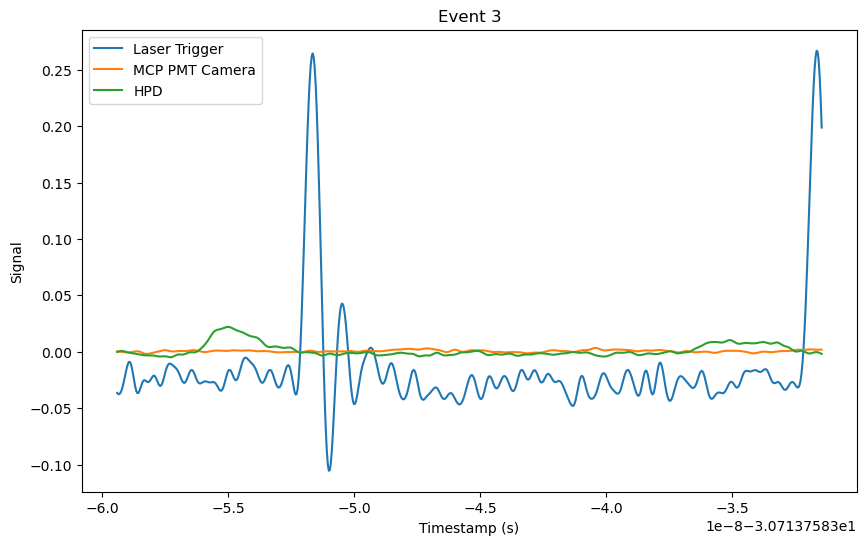

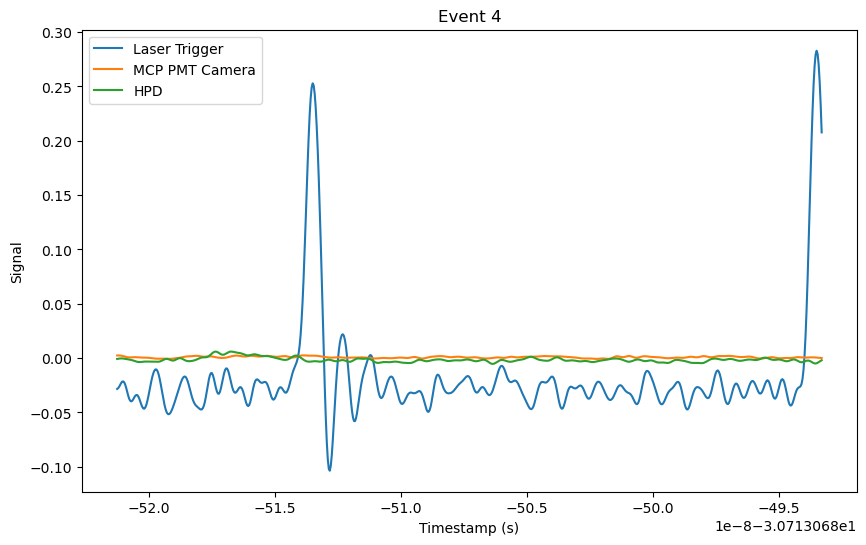

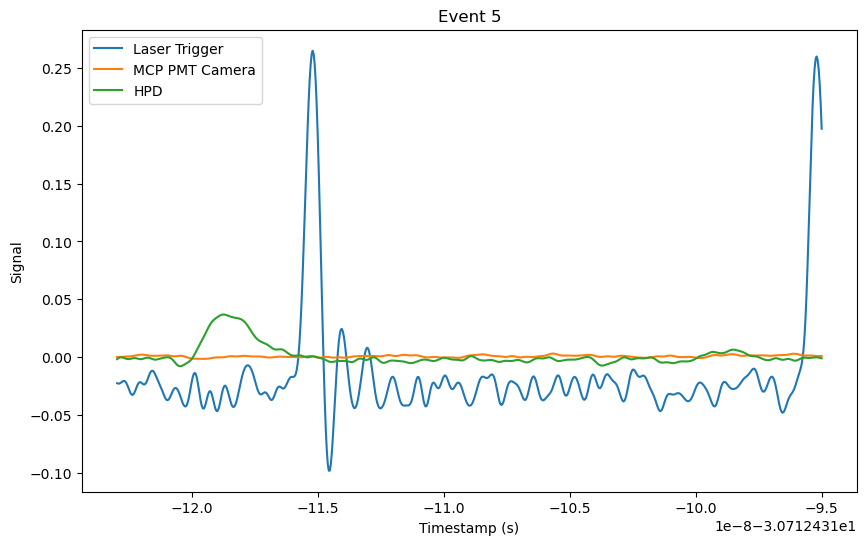

KeyboardInterrupt: 

In [118]:
for i in range(0,10):
    plot_target_event('data_oscill/cleaned_Run4.csv', target_event = i)

### making the code more flexible
- now I want the code to be more flexible and accept different numbers of channels between 2 and 4

In [116]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import math

RESOLUTION = 4e-11
BUFFER_SIZE = 50_000

def convert_csv_to_csv_and_parquet_dynamic(in_path, out_csv_path, out_parquet_path):
    buffer = []
    event_id = -1
    t0 = None
    idx = 0
    max_channels = 0
    parquet_writer = None

    with open(in_path) as fin, open(out_csv_path, "w") as fout:
        # CSV header: we will dynamically update later
        header_written = False

        for line in fin:
            line = line.strip()
            if not line:
                continue

            parts = line.split(";")

            # header = new event
            if len(parts) == 1:
                event_id += 1
                t0 = float(parts[0])
                idx = 0
                continue

            # data row = N channels
            if len(parts) >= 2:
                timestamp = t0 + idx * RESOLUTION
                idx += 1
                values = [float(x) for x in parts]

                max_channels = max(max_channels, len(values))

                buffer.append([event_id, timestamp] + values)

                # flush buffer if full
                if len(buffer) >= BUFFER_SIZE:
                    # CSV: pad rows so all have max_channels
                    if not header_written:
                        # write CSV header
                        header = ["event_id", "timestamp"] + [f"value_{i}" for i in range(max_channels)]
                        fout.write(",".join(header) + "\n")
                        header_written = True

                    for row in buffer:
                        row_padded = row + [math.nan]*(max_channels - (len(row)-2))
                        fout.write(",".join(map(str,row_padded)) + "\n")

                    # Parquet
                    df = pd.DataFrame(buffer)
                    if df.shape[1] < max_channels+2:
                        # pad columns
                        for i in range(df.shape[1]-2, max_channels):
                            df[i+2] = math.nan
                    df.columns = ["event_id", "timestamp"] + [f"value_{i}" for i in range(max_channels)]
                    table = pa.Table.from_pandas(df)
                    if parquet_writer is None:
                        parquet_writer = pq.ParquetWriter(out_parquet_path, table.schema, compression='snappy')
                    parquet_writer.write_table(table)

                    buffer = []

                continue

            raise ValueError(f"Unexpected format: {line}")

        # flush remaining buffer
        if buffer:
            if not header_written:
                header = ["event_id", "timestamp"] + [f"value_{i}" for i in range(max_channels)]
                fout.write(",".join(header) + "\n")
            for row in buffer:
                row_padded = row + [math.nan]*(max_channels - (len(row)-2))
                fout.write(",".join(map(str,row_padded)) + "\n")

            df = pd.DataFrame(buffer)
            if df.shape[1] < max_channels+2:
                for i in range(df.shape[1]-2, max_channels):
                    df[i+2] = math.nan
            df.columns = ["event_id", "timestamp"] + [f"value_{i}" for i in range(max_channels)]
            table = pa.Table.from_pandas(df)
            if parquet_writer is None:
                parquet_writer = pq.ParquetWriter(out_parquet_path, table.schema, compression='snappy')
            parquet_writer.write_table(table)

        if parquet_writer:
            parquet_writer.close()
